In [1]:
import os
import time
import sys
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree, distance_matrix, ConvexHull
from scipy.spatial.distance import pdist, squareform
import umap
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

2025-05-06 17:37:08.990657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# move to base directory
if os.path.basename(os.getcwd()) == "STmic":
    pass
else:
    os.chdir("../")

print(f"current directory: {os.getcwd()}")

current directory: /gpfs/commons/home/ikothari/STmic


In [3]:
# functions for building/subsetting different geometries from barcode arrays
from scripts.py.utils_geometry import *
# functions for simulating the molecular assay
from scripts.py.utils_simulation import *
# functions for building and assessing reconstructions
from scripts.py.utils_reconstruction import *

In [4]:
centers = np.load("/gpfs/commons/home/ikothari/STmic/notebooks/output/1umcenters.npy", allow_pickle=True)

In [5]:
#convert the center to a dataframe
bc_map = pd.DataFrame(centers, columns=['x', 'y'])
print(bc_map.head())
bc_map['x_y'] = bc_map['x'] * bc_map['y']

star = subset_points_within_star(bc_map, 75, 150, 5)
star.reset_index(inplace=True)

circle = subset_points_within_circle(bc_map, 150)
circle.reset_index(inplace=True)

square = subset_points_within_regular_polygon(bc_map, 4, 150)
square.reset_index(inplace=True)




            x           y
0  240.314578  249.712723
1  254.535911  134.102051
2   81.976166  138.203032
3  279.261804   37.959083
4  102.010661   55.310494


In [6]:
params_dict = {}

mers_values = [25]
reaction_time = [1]
num_reads_values = [50]

for i in range(len(mers_values)):
    for j in range(len(num_reads_values)):
        for k in range(len(reaction_time)):
            params_dict[f"{i}_{j}_{k}"] = {
                "mers_per_molc": mers_values[i],
                "num_reads": num_reads_values[j],
                "reaction_time": reaction_time[k],
                "plot": False,
            }

print(f"Testing {len(params_dict)} variations...")
print(num_reads_values)

Testing 1 variations...
[50]


In [ ]:
dist_matrix = build_distance_matrix(star)
for keys, params in params_dict.items():
        print(params)
        tally_matrix = simulate_concatemerization(
            bc_map=star, dist_matrix=dist_matrix, params=params,verbose=True
        )
        tally_matrix.setdiag(0)
        psuedo_distance_matrix = compute_pseudo_distance(tally_matrix)
        tally_umap = umap_driver(
            psuedo_distance_matrix, n_neighbors=75, min_dist=0.99, metric="euclidean",verbose=True
        )
        star["umap_1"] = pd.DataFrame(tally_umap)[0]
        star["umap_2"] = pd.DataFrame(tally_umap)[1]
        error, error_list = localreconstruction_KNN(star,15)

{'mers_per_molc': 25, 'num_reads': 50, 'reaction_time': 1, 'plot': False}
Compute noise matrix


Add noise to distance matrix
STARTING ACCUMULATION


/scratch/ipykernel_827628/103514463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star['error'] = error_list
/scratch/ipykernel_827628/103514463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star['umap_1'] = (star['umap_1'] - star['umap_1'].min()) / (star['umap_1'].max() - star['umap_1'].min())
/scratch/ipykernel_827628/103514463.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

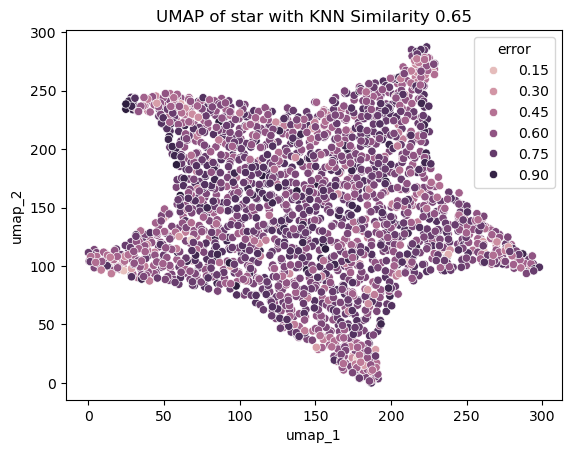

0.6509528272414871


In [ ]:
star['error'] = error_list
#normalize and then scale umap to 300 x 300
star['umap_1'] = (star['umap_1'] - star['umap_1'].min()) / (star['umap_1'].max() - star['umap_1'].min())
star['umap_2'] = (star['umap_2'] - star['umap_2'].min()) / (star['umap_2'].max() - star['umap_2'].min())
star['umap_1'] = star['umap_1'] * star['x'].max()
star['umap_2'] = star['umap_2'] * star['y'].max()

sns.scatterplot(x='umap_1', y='umap_2', data=star, hue='error')
plt.title(f"UMAP of star with KNN Similarity {error:.2f}")
plt.show()
print(error)



In [ ]:
star_mask = star.sample(frac=1).reset_index(drop=True)

/scratch/ipykernel_827628/1273045239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star['error'] = error_list


(2134, 2134)


Text(0.5, 1.0, 'Star KNN Similarity 0.6507966260543581, Frob Norm 64.28')

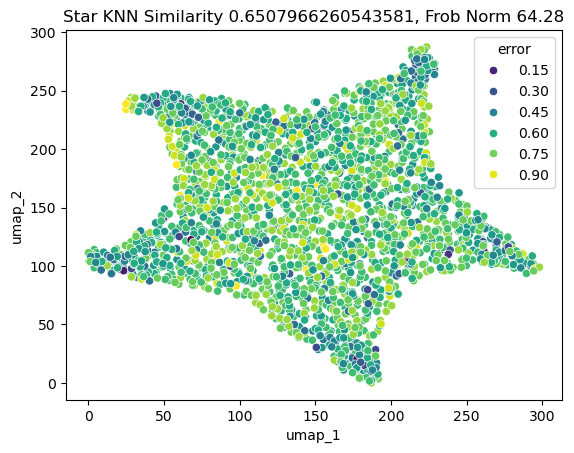

In [ ]:
error, error_list = localreconstruction_KNN(star, 15) 
star['error'] = error_list
frob_norm_umap = frobeniusglobalreconstruction(tally_umap,dist_matrix)
sns.scatterplot(data=star, x='umap_1', y='umap_2', hue='error', palette='viridis')
plt.title(f"Star KNN Similarity {error}, Frob Norm {frob_norm_umap:.2f}")


Procrustes Disparity: 0.00807437702071861


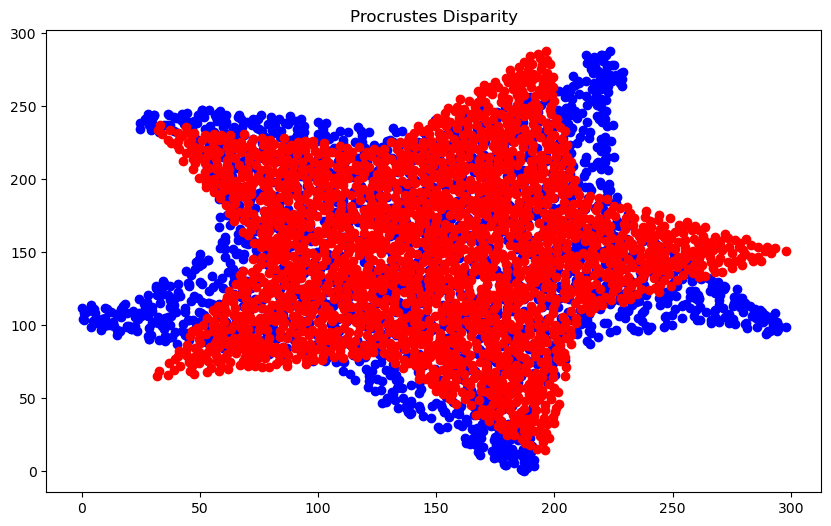

In [ ]:
# compute the procrustes disparity between umap and the original data
umap_values = star[['umap_1', 'umap_2']].values
original_values = star[['x', 'y']].values
procrustes_disparity = procrustes(umap_values, original_values)[2]

# plot the procrustes disparity
plt.figure(figsize=(10, 6))
plt.scatter(umap_values[:, 0], umap_values[:, 1], c='blue', label='UMAP')   
plt.scatter(original_values[:, 0], original_values[:, 1], c='red', label='Original')
plt.title('Procrustes Disparity')


print(f"Procrustes Disparity: {procrustes_disparity}")

# Compute Gromov Wasserstein Transport Plan

In [ ]:
import ot
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def compute_gw_mapping(umap_points, ground_truth):
    C1 = cdist(umap_points, umap_points, metric='sqeuclidean')
    C2 = cdist(ground_truth, ground_truth, metric='sqeuclidean')
    n = umap_points.shape[0]
    a = np.ones(n) / n
    b = np.ones(n) / n
    gw_coupling = ot.gromov.gromov_wasserstein(C1, C2, a, b, 'square_loss')
    row_ind, col_ind = linear_sum_assignment(-gw_coupling)
    mapped_indices_gw = np.zeros(n, dtype=int)
    mapped_indices_gw[row_ind] = col_ind
    return ground_truth[mapped_indices_gw]


def compute_ot_mapping(umap_points, ground_truth):
    C = cdist(umap_points, ground_truth, metric='sqeuclidean')
    row_ind, col_ind = linear_sum_assignment(C)  # minimize cost
    mapped_indices = np.zeros_like(row_ind)
    mapped_indices[row_ind] = col_ind
    return ground_truth[mapped_indices]

(2134, 2134)
Procrustes Disparity Gromov-Wasserstein: 0.0048188122852675895


Text(0.5, 1.0, 'Gromov-Wasserstein Mapping KNN Similarity 0.60, Procrustes Disparity 0.0048, Frobenius Norm 40.2575')

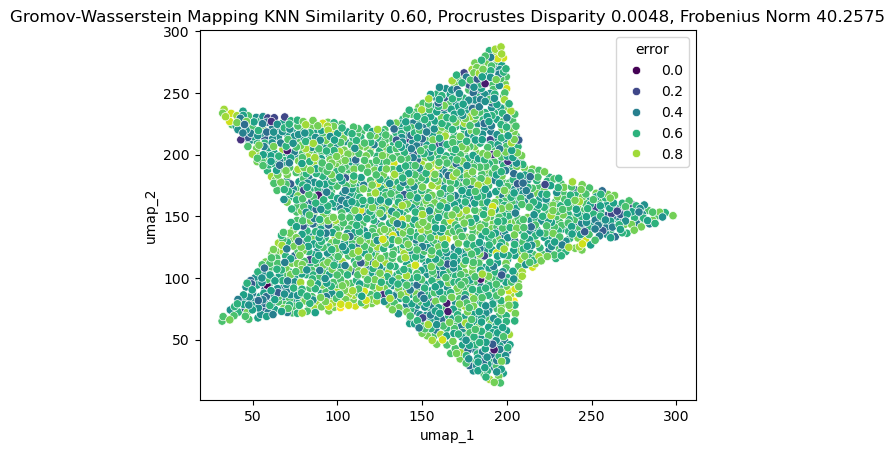

In [ ]:
umap_points = star[['umap_1', 'umap_2']].values
target_points = star[['x', 'y']].values
gw_mapping = compute_gw_mapping(umap_points, target_points)
star_gw = star.copy()
star_gw['umap_1'] = gw_mapping[:, 0]
star_gw['umap_2'] = gw_mapping[:, 1]
error_gw, error_list_gw = localreconstruction_KNN(star_gw, 15)
star_gw['error'] = error_list_gw
#compute procrustes disparity
frob_norm_gw = frobeniusglobalreconstruction(gw_mapping, dist_matrix)
procrustes_disparity_gw = procrustes(star_gw[['umap_1', 'umap_2']].values, star_gw[['x', 'y']].values)[2]
print(f"Procrustes Disparity Gromov-Wasserstein: {procrustes_disparity_gw}")
sns.scatterplot(data=star_gw, x='umap_1', y='umap_2', hue='error', palette='viridis')

plt.title(f'Gromov-Wasserstein Mapping KNN Similarity {error_gw:.2f}, Procrustes Disparity {procrustes_disparity_gw:.4f}, Frobenius Norm {frob_norm_gw:.4f}')



(2134, 2134)
Procrustes Disparity Optimal Transport: 0.014969842051831432


Text(0.5, 1.0, 'Optimal Transport Mapping KNN Similarity 0.57, Procrustes Disparity 0.0150, Frobenius Norm 70.3646')

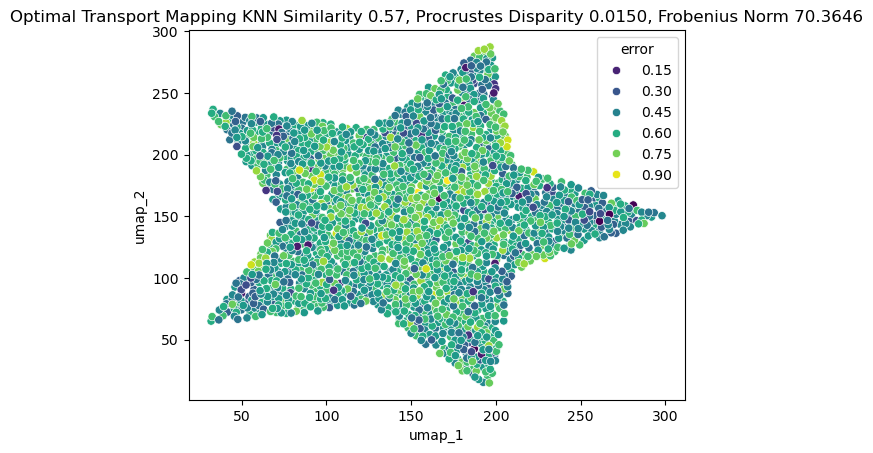

In [ ]:
umap_points = star[['umap_1', 'umap_2']].values
target_points = star[['x', 'y']].values
ot_mapping = compute_ot_mapping(umap_points, target_points)
star_ot = star.copy()
star_ot['umap_1'] = ot_mapping[:, 0]
star_ot['umap_2'] = ot_mapping[:, 1]
error_ot, error_list_ot = localreconstruction_KNN(star_ot, 15)
star_ot['error'] = error_list_ot
# compute procrustes disparity
procrustes_disparity_ot = procrustes(star_ot[['umap_1', 'umap_2']].values, star_ot[['x', 'y']].values)[2]
frob_norm_ot = frobeniusglobalreconstruction(ot_mapping,dist_matrix)
print(f"Procrustes Disparity Optimal Transport: {procrustes_disparity_ot}")
sns.scatterplot(data=star_ot, x='umap_1', y='umap_2', hue='error', palette='viridis')
plt.title(f'Optimal Transport Mapping KNN Similarity {error_ot:.2f}, Procrustes Disparity {procrustes_disparity_ot:.4f}, Frobenius Norm {frob_norm_ot:.4f}')


In [ ]:
%pip install pycpd


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


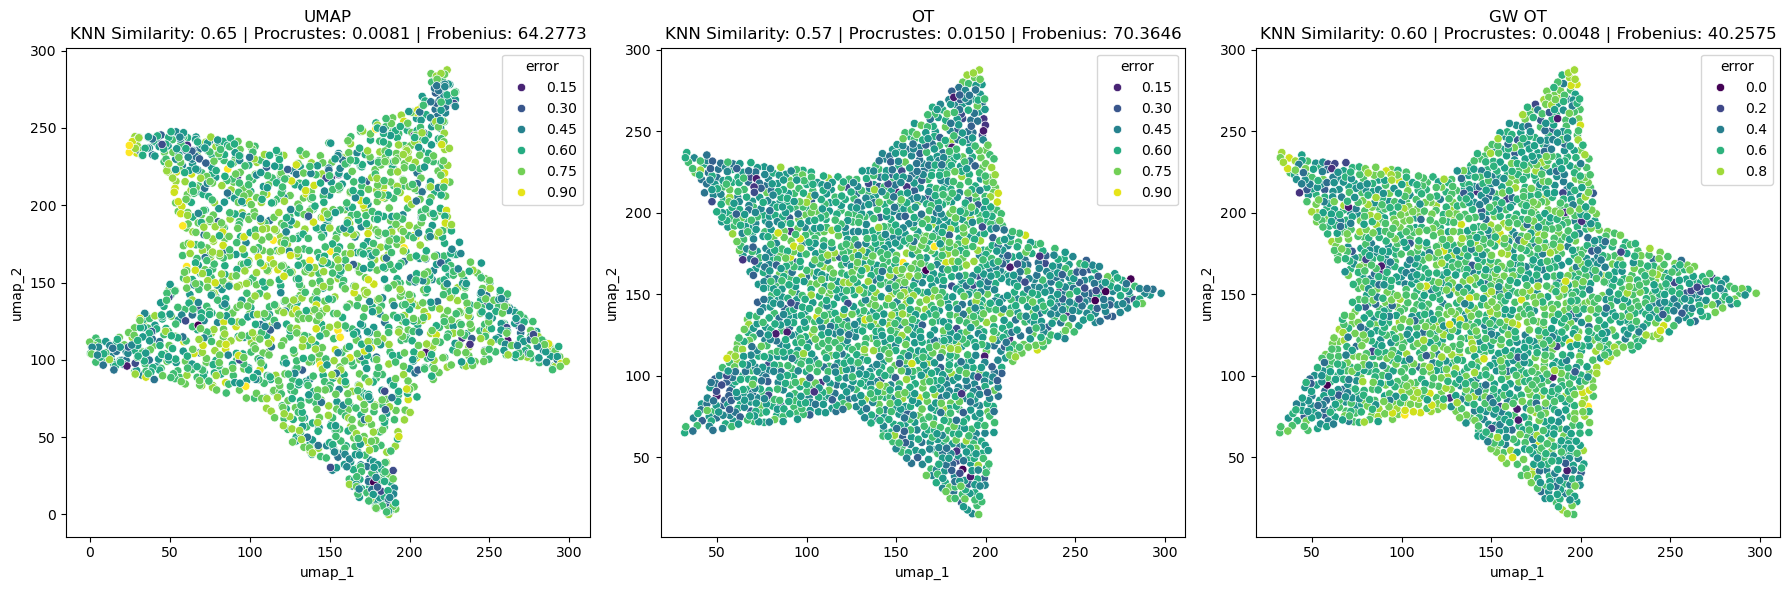

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# UMAP scatter plot
sns.scatterplot(ax=axes[0], data=star, x='umap_1', y='umap_2', hue='error', palette='viridis')
axes[0].set_title(f"UMAP\nKNN Similarity: {error:.2f} | Procrustes: {procrustes_disparity:.4f} | Frobenius: {frob_norm_umap:.4f}")
axes[0].set_xlabel("umap_1")
axes[0].set_ylabel("umap_2")

# OT scatter plot
sns.scatterplot(ax=axes[1], data=star_ot, x='umap_1', y='umap_2', hue='error', palette='viridis')
axes[1].set_title(f"OT\nKNN Similarity: {error_ot:.2f} | Procrustes: {procrustes_disparity_ot:.4f} | Frobenius: {frob_norm_ot:.4f}")
axes[1].set_xlabel("umap_1")
axes[1].set_ylabel("umap_2")

# GW OT scatter plot
sns.scatterplot(ax=axes[2], data=star_gw, x='umap_1', y='umap_2', hue='error', palette='viridis')
axes[2].set_title(f"GW OT\nKNN Similarity: {error_gw:.2f} | Procrustes: {procrustes_disparity_gw:.4f} | Frobenius: {frob_norm_gw:.4f}")
axes[2].set_xlabel("umap_1")
axes[2].set_ylabel("umap_2")

plt.tight_layout()
plt.show()

(2134, 2134)


Text(0.5, 1.0, 'CPD Mapping KNN Similarity 0.65, Procrustes Disparity 0.0081, Frobenius Norm 63.0724')

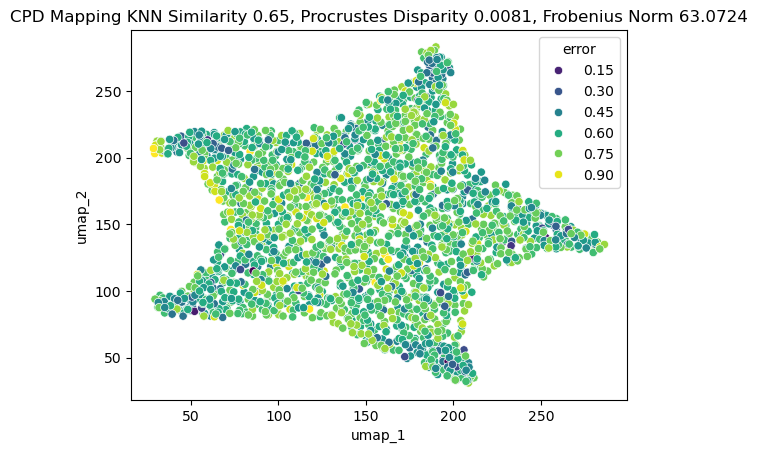

In [ ]:
from pycpd import RigidRegistration

def compute_cpd_mapping(umap_points, ground_truth):
    reg = RigidRegistration(X=ground_truth, Y=umap_points)
    TY, (s, R, t) = reg.register()
    return TY  # Transformed umap_points to align with ground_truth
umap_points = star[['umap_1', 'umap_2']].values
target_points = star_mask[['x', 'y']].values
cpd_mapping = compute_cpd_mapping(umap_points, target_points)
frob_norm = frobeniusglobalreconstruction(cpd_mapping, dist_matrix)
star_cpd = star.copy()
star_cpd['umap_1'] = cpd_mapping[:, 0]
star_cpd['umap_2'] = cpd_mapping[:, 1]
error_cpd, error_list_cpd = localreconstruction_KNN(star_cpd, 15)
star_cpd['error'] = error_list_cpd
# compute procrustes disparity
procrustes_disparity_cpd = procrustes(star_cpd[['umap_1', 'umap_2']].values, star_cpd[['x', 'y']].values)[2]
sns.scatterplot(data=star_cpd, x='umap_1', y='umap_2', hue='error', palette='viridis')
plt.title(f'CPD Mapping KNN Similarity {error_cpd:.2f}, Procrustes Disparity {procrustes_disparity_cpd:.4f}, Frobenius Norm {frob_norm:.4f}')

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# UMAP scatter plot
sns.scatterplot(ax=axes[0], data=star, x='umap_1', y='umap_2', hue='error', palette='viridis')
axes[0].set_title(f"UMAP\nKNN Similarity: {error:.2f} | Procrustes: {procrustes_disparity:.4f} | Frobenius: {frob_norm_umap:.4f}")
axes[0].set_xlabel("umap_1")
axes[0].set_ylabel("umap_2")

# OT scatter plot
sns.scatterplot(ax=axes[1], data=star_ot, x='umap_1', y='umap_2', hue='error', palette='viridis')
axes[1].set_title(f"OT\nKNN Similarity: {error_ot:.2f} | Procrustes: {procrustes_disparity_ot:.4f} | Frobenius: {frob_norm_ot:.4f}")
axes[1].set_xlabel("umap_1")
axes[1].set_ylabel("umap_2")

# GW OT scatter plot
sns.scatterplot(ax=axes[2], data=star_gw, x='umap_1', y='umap_2', hue='error', palette='viridis')
axes[2].set_title(f"GW OT\nKNN Similarity: {error_gw:.2f} | Procrustes: {procrustes_disparity_gw:.4f} | Frobenius: {frob_norm_gw:.4f}")
axes[2].set_xlabel("umap_1")
axes[2].set_ylabel("umap_2")

#CPD scatter plot
sns.scatterplot(ax=axes[3], data=star_cpd, x='umap_1', y='umap_2', hue='error', palette='viridis')
axes[3].set_title(f"CPD\nKNN Similarity: {error_cpd:.2f} | Procrustes: {procrustes_disparity_cpd:.4f} | Frobenius: {frob_norm:.4f}")
axes[3].set_xlabel("umap_1")
axes[3].set_ylabel("umap_2")
# Set the title for the entire figure
fig.suptitle("Comparison of Different Mapping Techniques", fontsize=16)


plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

Initial KNN similarity: 0.6162
2129 points have changed neighborhoods.
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)
(2134, 2134)


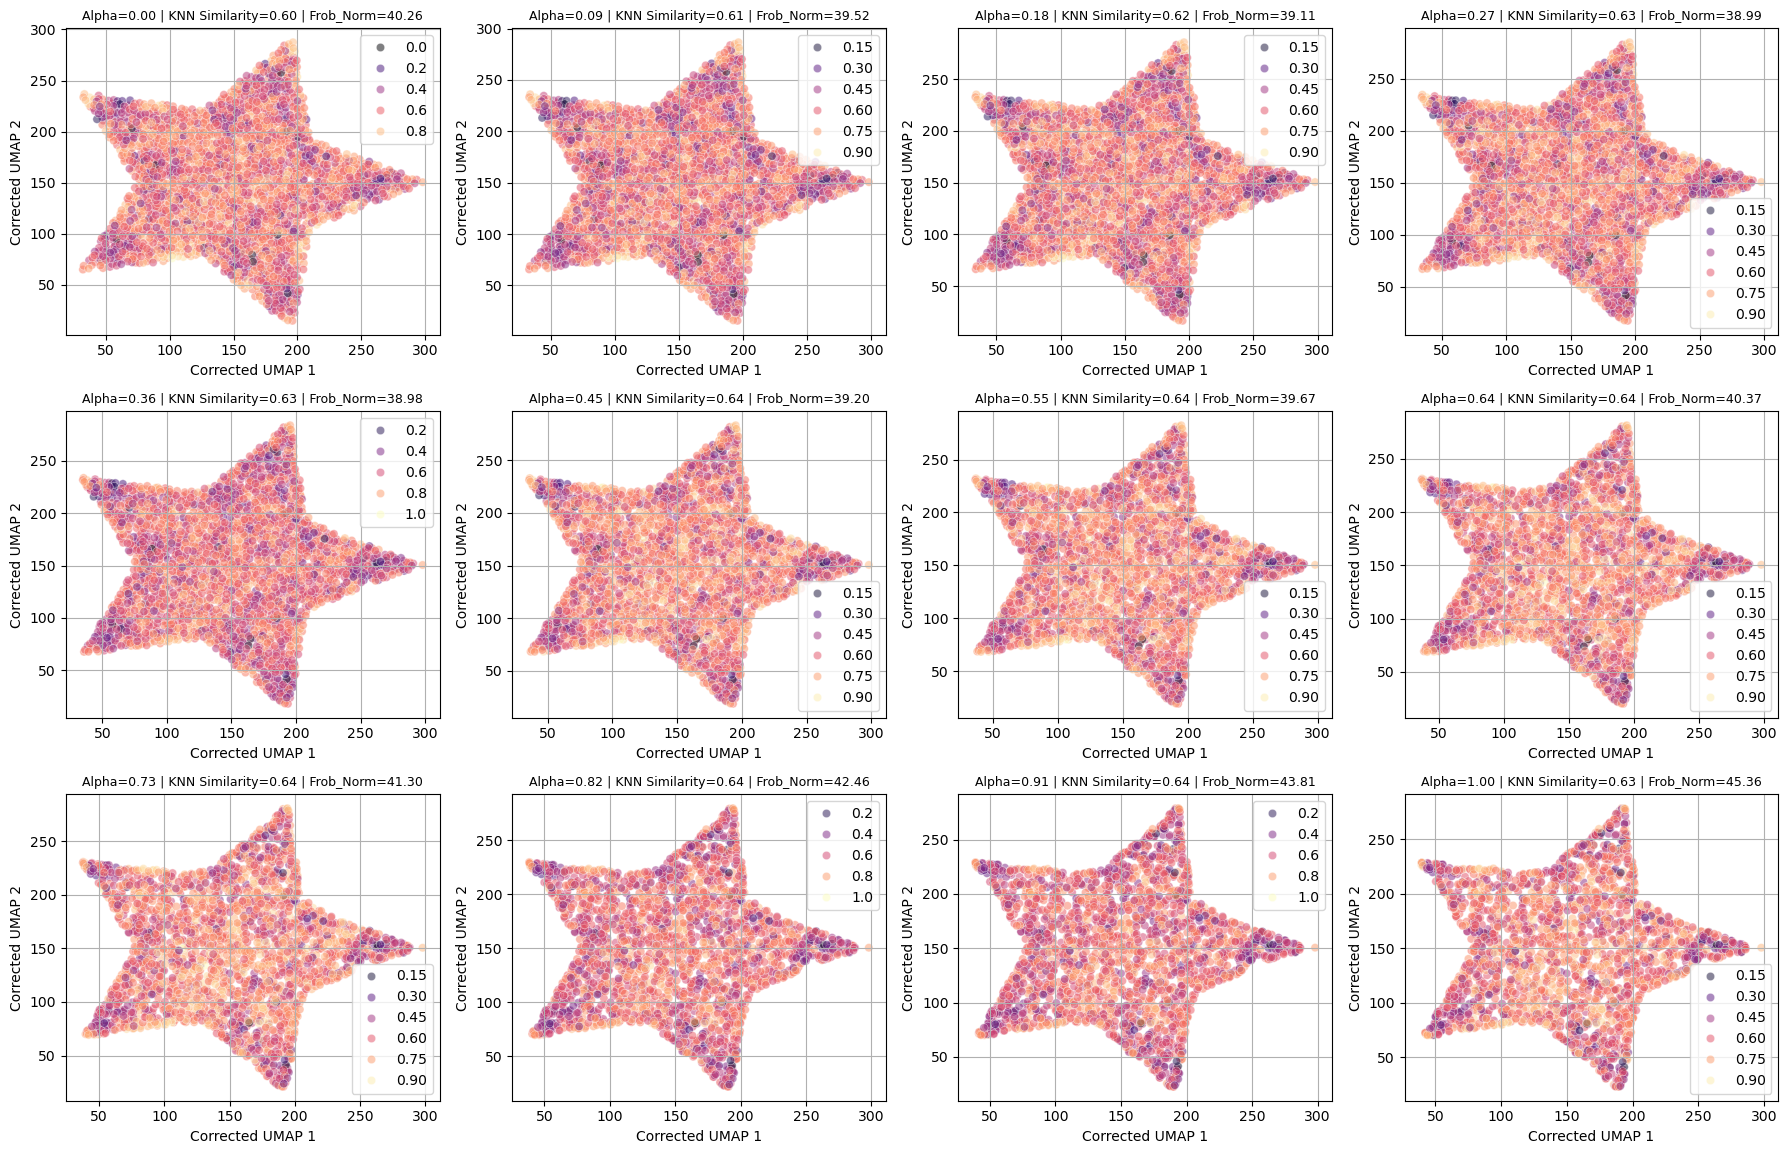

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# --- Helper Functions ---
def find_nearest_neighbors(points, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(points)
    distances, indices = nbrs.kneighbors(points)
    return distances, indices

def compare_knn(knn1, knn2):
    similarities = []
    indices1 = knn1[1]
    indices2 = knn2[1]
    for i in range(len(indices1)):
        intersection = len(set(indices1[i]).intersection(set(indices2[i])))
        union = len(set(indices1[i]).union(set(indices2[i])))
        similarities.append(intersection / union)
    return np.mean(similarities)

def per_point_knn_similarity(knn1, knn2):
    idx1 = knn1[1]
    idx2 = knn2[1]
    n, k = idx1.shape
    sims = np.zeros(n, dtype=float)
    for i in range(n):
        set1 = set(idx1[i])
        set2 = set(idx2[i])
        sims[i] = len(set1 & set2) / len(set1 | set2)
    return sims

# --- Main Experiment ---

# Precompute initial neighbors
mapped_points = star_gw[['umap_1', 'umap_2']].values
knn_mapped = find_nearest_neighbors(mapped_points, k=15)
knn_umap = find_nearest_neighbors(umap_points, k=15)

# Initial similarity
initial_similarity = compare_knn(knn_mapped, knn_umap)
print(f"Initial KNN similarity: {initial_similarity:.4f}")

# Bad points
sims = per_point_knn_similarity(knn_mapped, knn_umap)
bad_points = np.where(sims < 1.0)[0]
print(f"{len(bad_points)} points have changed neighborhoods.")

# Values to scan
alphas = np.linspace(0, 1.0, 12)  # 0.0, 0.1, ..., 1.0

# Create the grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(18, 12))  # 3 rows and 4 columns of subplots
axes = axes.flatten()  # Flatten to make indexing easier

for idx, alpha in enumerate(alphas):
    corrected = mapped_points.copy()

    # Move bad points toward their neighbors' centroid
    for i in bad_points:
        neigh_idxs = knn_umap[1][i]
        neighbor_positions = mapped_points[neigh_idxs]
        centroid = neighbor_positions.mean(axis=0)
        corrected[i] = (1 - alpha) * mapped_points[i] + alpha * centroid

    # Recompute neighbors
    knn_corrected = find_nearest_neighbors(corrected, k=15)
    new_similarity = compare_knn(knn_corrected, knn_umap)

    # Local reconstruction error
    star_eval = star.copy()
    star_eval['umap_1'] = corrected[:, 0]
    star_eval['umap_2'] = corrected[:, 1]
    error, error_list = localreconstruction_KNN(star_eval, 15)
    star_eval['error'] = error_list
    frob_norm = frobeniusglobalreconstruction(corrected, dist_matrix)

    # --- Scatterplot ---
    ax = axes[idx]
    sns.scatterplot(x='umap_1', y='umap_2', data=star_eval, hue='error', alpha=0.5, palette='magma', ax=ax)
    
    ax.set_title(f"Alpha={alpha:.2f} | KNN Similarity={error:.2f} | Frob_Norm={frob_norm:.2f}", fontsize=9)
    ax.set_xlabel('Corrected UMAP 1')
    ax.set_ylabel('Corrected UMAP 2')
    ax.legend()
    ax.grid()

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
from STalign import STalign
# load data
xI = np.array(star["umap_1"])
yI = np.array(star["umap_2"])
xJ = np.array(star_mask["x"])
yJ = np.array(star_mask["y"])

# rotational transformation- set at 0 because we align using procrustees
theta_deg = 0
theta0 = (np.pi / 180) * -theta_deg

# rotation matrix
# rotates about the origin
L = np.array([[np.cos(theta0), -np.sin(theta0)], [np.sin(theta0), np.cos(theta0)]])

source_L = np.matmul(L, np.array([xI, yI]))
xI_L = source_L[0]
yI_L = source_L[1]

# translation matrix
# effectively makes the rotation about the centroid of I (i.e the means of xI and yI])
# and also moves the centroid of I to the centroid of J
T = np.array(
    [
        np.mean(xI)
        - np.cos(theta0) * np.mean(xI)
        + np.sin(theta0) * np.mean(yI)
        - (np.mean(xI) - np.mean(xJ)),
        np.mean(yI)
        - np.sin(theta0) * np.mean(xI)
        - np.cos(theta0) * np.mean(yI)
        - (np.mean(yI) - np.mean(yJ)),
    ]
)

xI_L_T = xI_L + T[0]
yI_L_T = yI_L + T[1]


fig, ax = plt.subplots()
ax.scatter(
    xI_L_T, yI_L_T, s=1, alpha=0.1, label="source with initial affine transformation"
)
ax.scatter(xJ, yJ, s=1, alpha=0.1, label="target")
ax.legend(markerscale=10)

In [ ]:
# rasterize each image
XI, YI, I, fig = STalign.rasterize(xI_L_T, yI_L_T, dx=30, blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

XJ, YJ, J, fig = STalign.rasterize(xJ, yJ, dx=30, blur=1.5)
ax = fig.axes[0]
ax.invert_yaxis()

In [ ]:
import torch
import plotly
import requests

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

# keep all other parameters default
params = {"niter": 10000, "device": device, "epV": 50}

out = STalign.LDDMM([YI, XI], I, [YJ, XJ], J, **params)

In [ ]:
A = out["A"]
v = out["v"]
xv = out["xv"]
tpointsI = STalign.transform_points_source_to_target(
    xv, v, A, np.stack([yI_L_T, xI_L_T], 1)
)

# switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:, 1]
yI_LDDMM = tpointsI[:, 0]
fig, ax = plt.subplots()
# ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM, yI_LDDMM, s=1, alpha=0.1, label="source aligned")
ax.scatter(xJ, yJ, s=1, alpha=0.1, label="target")
ax.legend(markerscale=10)

In [ ]:
# frobenius norm
reconstruction = [xI_LDDMM, yI_LDDMM]
groundtruth = [np.array(star["x"]), np.array(star["y"])]
diff_x = star["x"] - xI_LDDMM.detach().numpy()
diff_y = star["y"] - yI_LDDMM.detach().numpy()

# Compute the mean squared error (MSE)
mse = ((diff_x**2).mean() + (diff_y**2).mean()) / 2

print(f"Mean Squared Error (MSE): {mse}")
print("RMSE", np.sqrt(mse))